# Influence of training data sample size on FACSIMILE performance

Here we explore the extent to which sample size for our training data affects the accuracy of predictions made by FACSIMILE.

## Imports

First, we import the necessary packages and set some plotting parameters.

In [1]:
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from sklearn.metrics import r2_score
from tqdm import tqdm

from facsimile.model import FACSIMILE
from facsimile.utils import (
    check_directories,
    set_style,
    tqdm_joblib,
    train_validation_test_split,
)

# Make sure we're in the root
check_directories()

# Make things look nice
set_style("style.mplstyle")

# Set matplotlib dpi
plt.rcParams["figure.dpi"] = 100

Font Heebo already available in Matplotlib.
Matplotlib style set to: style.mplstyle with font Heebo


## Load data

We first load in our data. This is a dataset of 1622 participants who completed the STICSA-T.

Each column corresponds to an item on the STICSA-T, and each row corresponds to a participant. There is one additional column (`subjectID`) that contains a unique identifier for each participant.

In [2]:
# Load the data
data = pd.read_csv("data/example_data.csv")

data.head()

,STICSA_T__1,STICSA_T__2,STICSA_T__3,STICSA_T__4,STICSA_T__5,STICSA_T__6,STICSA_T__7,STICSA_T__8,STICSA_T__9,STICSA_T__10,...,STICSA_T__13,STICSA_T__14,STICSA_T__15,STICSA_T__16,STICSA_T__17,STICSA_T__18,STICSA_T__19,STICSA_T__20,STICSA_T__21,subjectID
0,1.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,subject001_study1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,subject002_study1
2,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,subject003_study1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,subject004_study1
4,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,...,0.0,1.0,0.0,3.0,1.0,0.0,2.0,0.0,0.0,subject005_study1


### Calculate sum scores

The first step is to calculate the sum scores for the STICSA-T. This is done by summing the responses to each item.

In [3]:
# Sum across rows, excluding subjectID to get the sum score
sticsa_t_sumscores = data.drop("subjectID", axis=1).sum(axis=1)

# Turn this into a new dataframe with the subjectID and the sum score
sticsa_t_sumscores = pd.concat([data["subjectID"], sticsa_t_sumscores], axis=1)

# Rename the sum score column
sticsa_t_sumscores.columns = ["subjectID", "STICSA_T_sum"]

sticsa_t_sumscores.head()

,subjectID,STICSA_T_sum
0,subject001_study1,14.0
1,subject002_study1,2.0
2,subject003_study1,8.0
3,subject004_study1,0.0
4,subject005_study1,16.0


## Predicting sum scores

First, we'll use `FACSIMILE` to identify a reduced set of items that can be used to accurately predict sum scores. This could be useful if we want to reduce the length of the questionnaire while maintaining its predictive power, which is particularly useful for very long measures (perhaps not so much for the STICSA, which is already quite short but serves as a useful example).

### Split into training, testing, and validation sets

We split our data into three datasets:
1. Training set (`X_train`, `y_train`): Used to train candidate models.
2. Validation set (`X_val`, `y_val`): Used to select the best model.
3. Testing set (`X_test`, `y_test`): Used to evaluate the performance of the selected model.

We set the training set to be the largest, with 60% of the data. The other two sets are each 20% of the data.

For this, we use a utility function in `facsimile` called `train_test_val_split`. This also randomises the order of the data, which can be useful to ensure that the data is not ordered in any way that might bias the results.

In [5]:
X_train, X_val, X_test, y_train, y_val, y_test = train_validation_test_split(
    data.drop("subjectID", axis=1),
    sticsa_t_sumscores.drop("subjectID", axis=1),
    train_size=0.6,
    test_size=0.2,
    val_size=0.2,
)

## Test every possible number of retained items

Ordinarily, we would run an optimisation procedure that would identify the best number of items to retain. However, for the purposes of this example, we will test every possible number of retained items.

This is a little awkward to do, since we generally focus on values of the regularisation parameter $\alpha$ rather than the number of items directly, so we have to carefully work through alpha values that correspond to different numbers of items. This requires a bit of trial and error, since there isn't a clear, linear mapping between the two.

### Create some useful functions

First we'll create some functions to help with this.

In [81]:
def evaluate_every_n_items(
    X_train_sample: pd.DataFrame,
    y_train_sample: pd.DataFrame,
    X_val: pd.DataFrame,
    y_val: pd.DataFrame,
    starting_alpha: float = 20,
    min_alpha_step: float = 0.00001,
    max_alpha_step: float = 0.1,
    min_items: int = 2,
    max_items: int = 21,
    verbose: bool = False,
    max_iterations: int = 100000,
) -> pd.DataFrame:
    """
    Evaluates a FACSIMILE model for every possible number of included items,
    using adaptive step sizes for alpha.

    Args:
        X_train_sample (pd.DataFrame): Training data features
        y_train_sample (pd.DataFrame): Training data target
        X_val (pd.DataFrame): Validation data features
        y_val (pd.DataFrame): Validation data target
        starting_alpha (float): Initial alpha value
        min_alpha_step (float): Minimum step size for decreasing alpha
        max_alpha_step (float): Maximum step size for decreasing alpha
        min_items (int): Minimum number of items to include
        max_items (int): Maximum number of items to include
        verbose (bool): Whether to print progress
        max_iterations (int): Maximum number of iterations before raising an error

    Returns:
        pd.DataFrame: DataFrame containing alpha, number of included items, and R2 score
    """
    # Initialize variables
    alpha = starting_alpha
    last_alpha = starting_alpha
    last_n_items = min_items - 1
    current_alpha_step = min_alpha_step

    # Lists to store results
    alphas = []
    n_included = []
    r2s = []

    # Track total number of iterations so that we can raise an error
    # if we risk getting stuck in an infinite loop
    total_iterations = 0

    # Loop over the range of items to include
    while last_n_items < max_items:
        complete = False
        while not complete:
            # Initialize and fit the model
            model = FACSIMILE(alphas=(alpha,))

            # Add iteration
            total_iterations += 1
            if total_iterations > max_iterations:
                raise ValueError("Infinite loop detected")

            try:
                if verbose:
                    print(f"Fitting model with alpha: {alpha}")
                model.fit(X_train_sample, y_train_sample)
            except ValueError:
                # Handle alpha values too high by decreasing alpha
                last_alpha = alpha
                alpha -= current_alpha_step

                # Increase step size
                current_alpha_step = min(
                    current_alpha_step * 2, max_alpha_step
                )

                # Ensure that alpha doesn't go below 0
                if alpha < 0:
                    # If it's below 0, use the last value and reset the step size
                    current_alpha_step = min_alpha_step
                    alpha = last_alpha - current_alpha_step

                if verbose:
                    print(
                        f"Fitting failed. Changed alpha to {alpha}, \
                        step size: {current_alpha_step}"
                    )
                continue

            # Check if we've found a valid solution
            if model.n_included_items > last_n_items + 1:
                # Reset alpha to the last value that didn't skip items
                alpha = last_alpha

                # Reset step size
                current_alpha_step = min_alpha_step

                if verbose:
                    print(
                        f"Skipped items. Included items = {model.n_included_items}, \
                        last items = {last_n_items}. \
                        Changed alpha to {alpha}, step size: {current_alpha_step}"
                    )
                continue

            # If we found a solution with one more item
            if model.n_included_items > last_n_items:
                if verbose:
                    print(
                        f"Found solution with {model.n_included_items} items. \
                        Last: {last_n_items}"
                    )
                last_n_items = model.n_included_items
                alphas.append(alpha)
                last_alpha = alpha
                n_included.append(model.n_included_items)

                # Calculate R2 score
                pred = model.predict(X_val)
                r2 = r2_score(y_val, pred)
                r2s.append(r2)

                # Reset for next iteration
                complete = True
                current_alpha_step = min_alpha_step  # Reset step size

            else:
                # Record the last alpha value that didn't make progress - used
                # to adjust alpha for
                # skipped items
                last_alpha = alpha

                # Decrease alpha if model didn't progress
                alpha -= current_alpha_step
                current_alpha_step = min(
                    current_alpha_step * 2, max_alpha_step
                )

                # Ensure that alpha doesn't go below 0
                if alpha < 0:
                    # If it's below 0, use the last value and reset the step size
                    current_alpha_step = min_alpha_step
                    alpha = last_alpha - current_alpha_step

                if verbose:
                    print(
                        f"Didn't progress. Changed alpha to {alpha}, \
                        step size: {current_alpha_step}"
                    )

    # Create results DataFrame
    results = pd.DataFrame(
        {"alpha": alphas, "n_included": n_included, "r2": r2s}
    )

    return results


def evaluate_sample_iteration(
    sample_size: int, iteration: int, seed: int, verbose: bool = False
) -> pd.DataFrame:
    """
    Evaluates a sample iteration by sampling the training data and evaluating
    the model.

    Args:
        sample_size (int): The size of the sample to draw from the training
            data.
        iteration (int): The iteration number.
        seed (int): The random seed for reproducibility.
        verbose (bool): Whether to print progress.

    Returns:
        pd.DataFrame: DataFrame containing the evaluation results.
    """
    # Sample the training data
    X_train_sample = X_train.sample(sample_size, random_state=seed)
    y_train_sample = y_train.loc[X_train_sample.index]

    results = evaluate_every_n_items(
        X_train_sample, y_train_sample, X_val, y_val, verbose=verbose
    )

    # Add the sample size and iteration number to the results
    results["sample_size"] = sample_size
    results["iteration"] = iteration

    return results


def evaluate_sample(iteration_tuples: List[tuple]) -> List[pd.DataFrame]:
    """
    Evaluates multiple sample iterations.

    Args:
        iteration_tuples (List[tuple]): List of tuples containing iteration
            number, sample size, and seed.

    Returns:
        List[pd.DataFrame]: List of DataFrames containing the evaluation
            results for each iteration.
    """
    results = []
    for iteration, sample_size, seed in iteration_tuples:
        try:
            result = evaluate_sample_iteration(sample_size, iteration, seed)
            results.append(result)
        except ValueError as e:
            raise ValueError(
                f"Failed for {sample_size}, {iteration}, {seed}"
            ) from e
    return results

### Run the evaluation procedure

We next run the evaluation procedure, which aims to test every number of items that could be retained across a range of sample sizes, trying out 1000 different datasets for each so that we can get a sense of the variability in the results.

Note that this is fairly computationally intensive, we run it across 64 CPU cores here to speed things up.

In [ ]:
# Sample sizes to test
training_sample_sizes = [50, 100, 200, 300, 400, 500]

# Number of iterations per sample size
n_iterations = 1000

# List to store dataframes
output_dfs = []

# Set up a random number generator
rng = np.random.RandomState(42)

# Run evaluation in parallel using chunks - avoids parallel overhead
# associated with small tasks

# Create tuples indicating iteration, sample size, and seed
iteration_tuples = [
    (i, sample_size, rng.randint(0, 1000))
    for i in range(n_iterations)
    for sample_size in training_sample_sizes
]

# Number of cpus to use
n_cpus = 64

# Split the tuples into chunks
chunk_size = len(iteration_tuples) // n_cpus
chunks = [
    iteration_tuples[i : i + chunk_size]
    for i in range(0, len(iteration_tuples), chunk_size)
]

# Run chunks in parallel
with tqdm_joblib(tqdm(desc="Evaluation", total=len(chunks))):
    results = Parallel(n_jobs=n_cpus)(
        delayed(evaluate_sample)(chunk) for chunk in chunks
    )

# Concatenate the list of lists of dataframes into a single dataframe
results_df = pd.concat([pd.concat(res) for res in results])

Evaluation:   0%|                                                                                                                                                                                                 | 0/65 [00:00<?, ?it/s]

Evaluation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [01:17<00:00,  1.20s/it]


### Plot the results

We then want to see how the number of items retained and the sample size affect the accuracy of the predictions made by FACSIMILE.

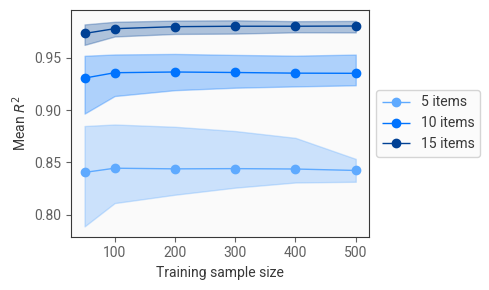

In [ ]:
f, ax = plt.subplots(figsize=(5, 3))

# Number of items included to look at
n_included = [5, 10, 15]

# Colors to use
colours = ['#5faaff', '#0073FE', '#004195']

for i, n in enumerate(n_included):

    # Get subset of results
    subset_df = results_df[results_df["n_included"] == n]

    # Get mean and 95% CI for each sample size
    mean = subset_df.groupby("sample_size")["r2"].mean()
    ci = subset_df.groupby("sample_size")["r2"].quantile([0.025, 0.975]).unstack().reset_index()
    ci.columns = ["sample_size", "lower", "upper"]

    # Plot the mean across iterations
    ax.plot(training_sample_sizes, mean, marker="o", label=f"{n} items", color=colours[i])

    # Add shaded region for the standard deviation
    ax.fill_between(
        training_sample_sizes,
        ci["lower"],
        ci["upper"],
        alpha=0.3,
        color=colours[i],
    )

    ax.set_xlabel("Training sample size")
    ax.set_ylabel("Mean $R^2$")

# Put a legend outside to the right
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

plt.tight_layout()